In [4]:
import gdal
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
from glob import glob
import shapely
import random
from tqdm import tqdm
from collections import Counter
from pybob.GeoImg import GeoImg
import osr
from pybob.image_tools import create_mask_from_shapefile
import gc
import imageio
import time
import shutil
import warnings
warnings.filterwarnings('ignore')

In [5]:
def get_mask(maskshp,geotrf,shape,p='4326'):
    img=np.zeros((shape[0],shape[1]))
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    
    trf=(geotrf[0], geotrf[1], geotrf[2], geotrf[3], geotrf[4], geotrf[5])
    drv = gdal.GetDriverByName('MEM')
    dst = drv.Create('', shape[1], shape[0], 1, gdal.GDT_UInt16)

    sp = dst.SetProjection(proj)
    sg = dst.SetGeoTransform(trf)

    wa = dst.GetRasterBand(1).WriteArray(img)
    del wa, sg, sp
    img_bob = GeoImg(dst)
    mask = create_mask_from_shapefile(img_bob, maskshp)
    return mask
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def tif_save_bands(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[2],img.shape[1],img.shape[0],6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    for i in range(img.shape[0]):
        new_img.GetRasterBand(i+1).WriteArray(img[i,:,:])
    new_img.FlushCache()
    del new_img
def tif_save(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[1],img.shape[0],1,6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    new_img.GetRasterBand(1).SetNoDataValue(0)
    new_img.GetRasterBand(1).WriteArray(img)
    new_img.FlushCache()
    del new_img

# 分区mask

In [35]:
labels_date={'A':['20210910'],'A-B':['20220227','20220309'],'B':['20220314'],'B-C':['20220319','20220324','20220329','20220403','20220428','20220503'],'C':['20220508'],'C-Z':['20220523','20220528','20220602','20220607','20220612','20220617','20220622','20220627']}
points_path='/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C_2022-05-07.shp'

# 制作patch的label

In [38]:
def get_dam_mask(point,patch_file,weight):
    trf=torch.load(patch_file)['trf']
    shape=torch.load(patch_file)['shape'][1]
    p_coor=[shapely.geometry.mapping(list(point)[i])['coordinates'] for i in range(len(point))]
    mask=np.zeros((shape[1],shape[2]))
    p_x_y=[[int((i[0]-trf[0])/trf[1]),int((i[1]-trf[3])/trf[5])] for i in p_coor]
    for i in p_x_y:
        try:
            mask[i[1],i[0]]+=weight
        except:
            pass
    return mask
def get_mask(points_path,patch_path):
    n=points_path.split("_")[-2]
    df=gpd.read_file(points_path)
    print(len(df))
    point_num={}
    point=df[df['DmgCls']=='Destroyed']['geometry']
    point_num['destroyed']=len(point)
    print('destroyed:',len(point))
    mask_destroyed=get_dam_mask(point,patch_path,1)
    point=df[df['DmgCls']=='Severe Damage']['geometry']
    point_num['severe']=len(point)
    print('Severe Damage:',len(point))
    mask_severe=get_dam_mask(point,patch_path,1)
    point=df[df['DmgCls']=='Moderate Damage']['geometry']
    point_num['moderate']=len(point)
    print('Moderate Damage:',len(point))
    mask_moderate=get_dam_mask(point,patch_path,1)

    mask=mask_destroyed*6+mask_severe*3+mask_moderate
    date=df['SensDt'][0]
    print(f'{n}  {date}得分',dict(Counter(list(mask.flatten()))))
    mask_type=np.zeros(mask.shape)
    mask_type[mask>0]=1
    mask_type[mask>=6]=2
    print(f'{date}损毁类型',Counter(list(mask_type.flatten())))
    all_mask=[mask_destroyed,mask_severe,mask_moderate,mask,mask_type]
    info='5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
    result={'info':info,'point_num':point_num,'mask':all_mask}
    return result

In [80]:
points_list=['/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp',
'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C_2022-05-07.shp']
for point_path in points_list:
    patch_path='/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_area4_info.pth'
    result=get_mask(point_path,patch_path)
    save_path=point_path.replace('.shp','_size_6_dammask.pth.tar').replace('/home/hk/python_script/Ukraine/data/UNOSAT/U/','/data4/Ukraine_img/M_and_L/')
    print(save_path)
    torch.save(result,save_path)
    print('__________________________SAVE SUCCESS__________________________')

# for point_path in points_list:
#     patch_path='/data4/Ukraine_img/U_bandother/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_3_info.pth'
#     result=get_mask(point_path,patch_path)
#     torch.save(result,point_path.replace('.shp','_size_3_dammask.pth.tar'))
#     print('__________________________SAVE SUCCESS__________________________')


750
destroyed: 61
Severe Damage: 300
Moderate Damage: 311
B  2022-03-14得分 {0.0: 222218, 3.0: 192, 6.0: 58, 1.0: 229, 4.0: 18, 9.0: 14, 7.0: 8, 2.0: 19, 14.0: 1, 5.0: 5, 12.0: 3, 10.0: 1, 21.0: 1, 11.0: 1, 15.0: 1}
2022-03-14损毁类型 Counter({0.0: 222218, 1.0: 463, 2.0: 88})
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar
__________________________SAVE SUCCESS__________________________
5571
destroyed: 312
Severe Damage: 2089
Moderate Damage: 2972
C  2022-05-12得分 {0.0: 219385, 3.0: 706, 1.0: 1495, 6.0: 258, 5.0: 71, 9.0: 94, 8.0: 31, 16.0: 13, 12.0: 30, 18.0: 13, 10.0: 45, 15.0: 15, 2.0: 226, 4.0: 235, 29.0: 1, 7.0: 87, 13.0: 25, 11.0: 11, 17.0: 4, 20.0: 3, 19.0: 4, 24.0: 2, 21.0: 4, 14.0: 7, 28.0: 1, 32.0: 1, 27.0: 2}
2022-05-12损毁类型 Counter({0.0: 219385, 1.0: 2733, 2.0: 651})
/data4/Ukraine_img/M_and_L/Livoberezhyny_C_2022-05-07_size_6_dammask.pth.tar
__________________________SAVE SUCCESS__________________________


In [104]:
f

'/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_areaall_info.pth'

In [106]:
for f in fs:
    data=torch.load(f)
    data['img10'][mask==0]=0
    torch.save(data,f.replace('_areaall_','_areaL_'))


In [96]:
mask=torch.load('/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_area1_info.pth')['img10']+ \
torch.load('/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_area2_info.pth')['img10']+ \
torch.load('/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_area3_info.pth')['img10']+ \
torch.load('/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_area4_info.pth')['img10']

In [54]:
fs=glob('/data4/Ukraine_img/M_and_L/*_areaall_info.pth')
fs.sort()
fs[11]

'/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_areaall_info.pth'

In [107]:
fs=glob('/data4/Ukraine_img/M_and_L/*_areaL_info.pth')
fs.sort()
dammasks_path={'all':{'A': None,
  'B': '/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar',
  'C': '/data4/Ukraine_img/M_and_L/Livoberezhyny_C_2022-05-07_size_6_dammask.pth.tar',
  'Z':None}}
img_pathes={}
img_pathes1={}
img_pathes1['A']=[fs[0]]
img_pathes1['A-B']=fs[1:3]
img_pathes1['B']=[fs[3]]
img_pathes1['B-C']=fs[4:10]
img_pathes1['C']=[fs[10]]
img_pathes1['C-Z']=fs[11:]
img_pathes['all']=img_pathes1
img_pathes

{'all': {'A': ['/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_areaL_info.pth'],
  'A-B': ['/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_areaL_info.pth',
   '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_areaL_info.pth'],
  'B': ['/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_areaL_info.pth'],
  'B-C': ['/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_areaL_info.pth',
   '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_areaL_info.pth',
   '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_areaL_info.pth',
   '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_areaL_info.pth',
   '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_areaL_info.pth',
   '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_areaL_info.pth'],
  'C': ['/data4/

# 制作样本

In [77]:
# masks={
#     'A':None,
#     'B':glob(f'/data2/Syria_img/{city}_B_*_treated_size_120_dammask.pth.tar')[0],
#     'C':glob(f'/data2/Syria_img/{city}_C_*_treated_size_120_dammask.pth.tar')[0],
#     'D':glob(f'/data2/Syria_img/{city}_D_*_treated_size_120_dammask.pth.tar')[0],
#     'Z':None
# }


def get_samples(pre_patch,post_patch,dammask_after,dammask_now,dammask_before):
        # if pre_patch[0].shape!=post_patch[0].shape:
        #         raise('SHAPE ERROR')
        if pre_patch[0].shape[0]!=4 or post_patch[0].shape[0]!=4:
                raise
        if pre_patch[1].shape[0]!=6 or post_patch[1].shape[0]!=6:
                raise
                               
        shape=pre_patch[0].shape
        print(shape)
        zz=np.zeros((shape[1],shape[2]))
        samples=[]
        if dammask_now is not None:
                for x in range(shape[1]):
                        for y in range(shape[2]):
                                
                                if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                        continue
                                else:
                                        samples.append([[x,y],[None,[int(i[x,y]) for i in dammask_now['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                        zz[x,y]=1
        else:
                if dammask_before is None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if dammask_after['mask'][0][x,y]==0:
                                                        samples.append([[x,y],[None,[int(i[x,y]) for i in dammask_after['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                if dammask_after is None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if dammask_before['mask'][0][x,y]>0:
                                                        samples.append([[x,y],[[int(i[x,y]) for i in dammask_before['mask']],None],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                if dammask_before is not None and dammask_after is not None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if (dammask_after['mask'][0][x,y]>0 and dammask_before['mask'][0][x,y]>0) or (dammask_after['mask'][0][x,y]==0 and dammask_before['mask'][0][x,y]==0):
                                                        samples.append([[x,y],[[int(i[x,y]) for i in dammask_before['mask']],[int(i[x,y]) for i in dammask_after['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                                        
        return samples,zz

In [64]:
dammasks_path

{'all': {'A': None,
  'B': '/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar',
  'C': '/data4/Ukraine_img/M_and_L/Livoberezhyny_C_2022-05-07_size_6_dammask.pth.tar',
  'Z': None}}

-------------------------------------
['A', 'A-B', 'B', 'B-C', 'C', 'C-Z']


A-B
loading mask: B
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load img: A-B
['/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_areaL_info.pth']
/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_areaL_info.pth


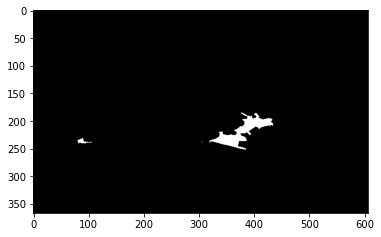

(4, 367, 607, 6, 6)
writing samples 2086


100%|██████████| 2086/2086 [00:00<00:00, 139050.22it/s]


/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


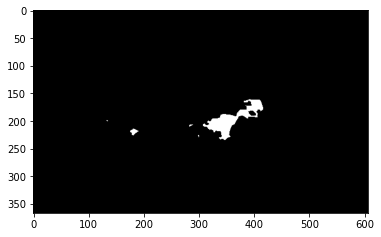

(4, 367, 607, 6, 6)
writing samples 2191


100%|██████████| 2191/2191 [00:00<00:00, 144028.21it/s]




B
loading mask: B
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar
load img: B
['/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_areaL_info.pth']
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


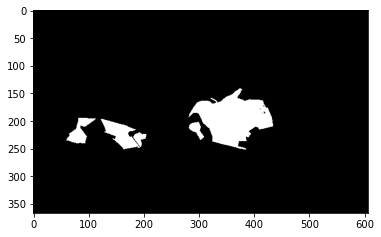

(4, 367, 607, 6, 6)
writing samples 11727


100%|██████████| 11727/11727 [00:00<00:00, 309811.50it/s]




B-C
loading mask: B and C
/data4/Ukraine_img/M_and_L/Livoberezhyny_B_2022-03-14_size_6_dammask.pth.tar
/data4/Ukraine_img/M_and_L/Livoberezhyny_C_2022-05-07_size_6_dammask.pth.tar
load img: B-C
['/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_areaL_info.pth']
/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


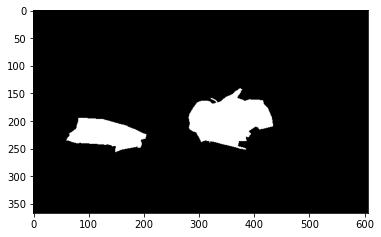

(4, 367, 607, 6, 6)
writing samples 14733


100%|██████████| 14733/14733 [00:00<00:00, 329703.51it/s]


/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


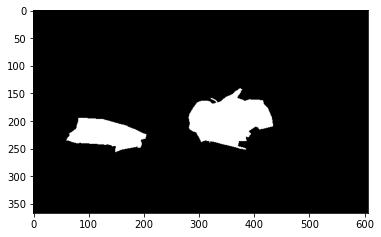

(4, 367, 607, 6, 6)
writing samples 14734


100%|██████████| 14734/14734 [00:00<00:00, 318634.67it/s]


/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


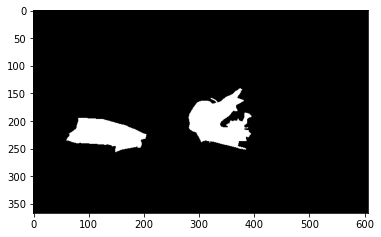

(4, 367, 607, 6, 6)
writing samples 11689


100%|██████████| 11689/11689 [00:00<00:00, 294569.23it/s]


/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


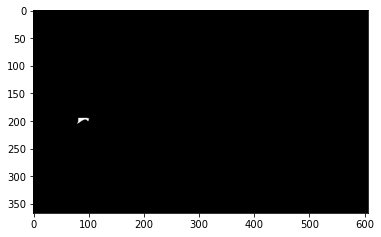

(4, 367, 607, 6, 6)
writing samples 76


100%|██████████| 76/76 [00:00<00:00, 68759.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_areaL_info.pth


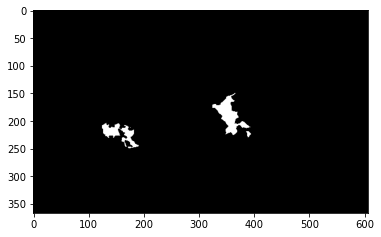

(4, 367, 607, 6, 6)
writing samples 2458


100%|██████████| 2458/2458 [00:00<00:00, 148956.82it/s]


/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


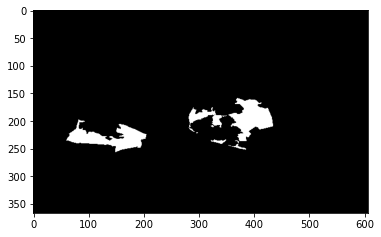

(4, 367, 607, 6, 6)
writing samples 7069


100%|██████████| 7069/7069 [00:00<00:00, 245487.88it/s]




C
loading mask: C
/data4/Ukraine_img/M_and_L/Livoberezhyny_C_2022-05-07_size_6_dammask.pth.tar
load img: C
['/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_areaL_info.pth']
/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


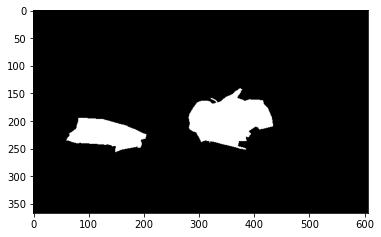

(4, 367, 607, 6, 6)
writing samples 14962


100%|██████████| 14962/14962 [00:00<00:00, 328846.94it/s]




C-Z
loading mask: C
/data4/Ukraine_img/M_and_L/Livoberezhyny_C_2022-05-07_size_6_dammask.pth.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


load img: C-Z
['/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2_size_6_areaL_info.pth', '/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2_size_6_areaL_info.pth']
/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_areaL_info.pth


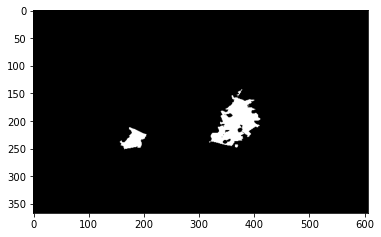

(4, 367, 607, 6, 6)
writing samples 90


100%|██████████| 90/90 [00:00<00:00, 76429.92it/s]


/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


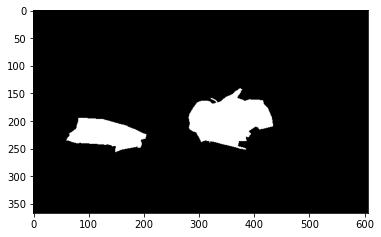

(4, 367, 607, 6, 6)
writing samples 256


100%|██████████| 256/256 [00:00<00:00, 103085.81it/s]


/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


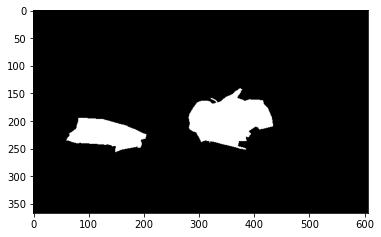

(4, 367, 607, 6, 6)
writing samples 256


100%|██████████| 256/256 [00:00<00:00, 104929.33it/s]


/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


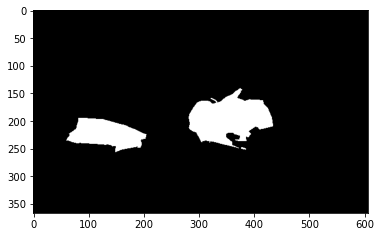

(4, 367, 607, 6, 6)
writing samples 253


100%|██████████| 253/253 [00:00<00:00, 103255.71it/s]


/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


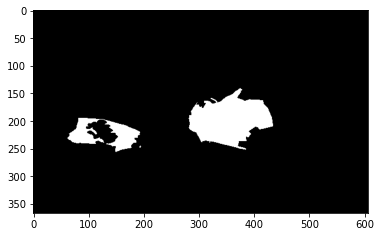

(4, 367, 607, 6, 6)
writing samples 197


100%|██████████| 197/197 [00:00<00:00, 98401.56it/s]


/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


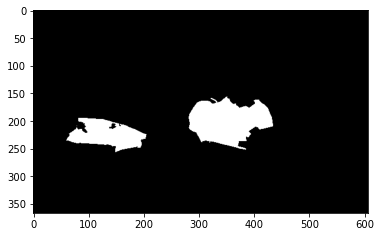

(4, 367, 607, 6, 6)
writing samples 255


100%|██████████| 255/255 [00:00<00:00, 102712.72it/s]


/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2_size_6_areaL_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


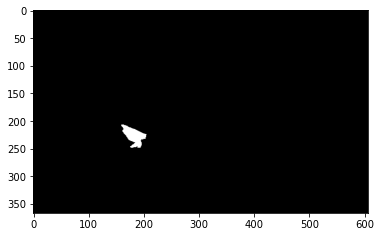

(4, 367, 607, 6, 6)
writing samples 42


100%|██████████| 42/42 [00:00<00:00, 51720.72it/s]


/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2_size_6_areaL_info.pth


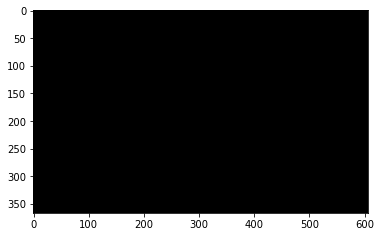

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]


In [108]:
cities=dammasks_path.keys()
for city in cities:
    print('-------------------------------------')
    cityimg_pathes10=img_pathes[city]

    # print(city)
    masks10=dammasks_path[city]

    # print(masks)
    k_interval=list(cityimg_pathes10.keys())

    print(k_interval)
    k_interval.remove('A')
    for k_ in k_interval:
        print()
        print()
        print(k_)
        if len(k_)==1:
            print('loading mask:',k_)
            print(masks10[k_])
            mask_now=torch.load(masks10[k_])
            mask_before=None
            mask_after=None
        else:
            if 'A' in k_:
                print('loading mask:',k_[2])
                print(masks10[k_[2]])
                mask_now=None
                mask_before=None
                mask_after=torch.load(masks10[k_[2]])
            elif 'Z' in k_:
                print('loading mask:',k_[0])
                print(masks10[k_[0]])
                mask_now=None
                mask_before=torch.load(masks10[k_[0]])
                mask_after=None
            else:
                print('loading mask:',k_[0],'and',k_[2])
                print(masks10[k_[0]])
                print(masks10[k_[2]])
                mask_now=None
                mask_before=torch.load(masks10[k_[0]])
                mask_after=torch.load(masks10[k_[2]])  
        pre10_path=cityimg_pathes10['A'][0]
        pre_info=torch.load(pre10_path)
        pre_img=[pre_info['img10'],pre_info['img20']]
        post10_pathes=cityimg_pathes10[k_]
        if len(post10_pathes)==0:
            continue
        post10_pathes.sort()
        print('load img:',k_)
        print(post10_pathes)
        for post10_path in post10_pathes:
            print(post10_path)
            post_info=torch.load(post10_path)
            post_img=[post_info['img10'],post_info['img20']]
            plt.imshow(post_img[0][:3,:,:,1,1].transpose((1,2,0)))
            plt.show()
            samples,zz=get_samples(pre_img,post_img,mask_after,mask_now,mask_before)
            print('writing samples',len(samples))
            time.sleep(2)


            samples_root='/ssd/hk/Ukraine_samples/samplesv2/samples/'
            img_id=os.path.basename(post10_path).split('_size')[0].replace('_','-')

            samples_pathes=[samples_root+f'{city}_{img_id}_{str(i[0][0]).zfill(3)+str(i[0][1]).zfill(3)}.pth' for i in samples]
            info=[]

            for i in tqdm(range(len(samples))):
                    # '5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
                    info.append([samples_pathes[i],samples[i][0],samples[i][1]])
                    if not os.path.exists(samples_pathes[i]):
                        torch.save(samples[i],samples_pathes[i])
            info_dict={'readme':'4个字段\n 1:pre图像路径\n 2:post图像路径\n 3:图像坐标\n 4:损毁信息\n 损毁信息有5层\n 5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6', 'info':info}
            s_path=f'/ssd/hk/Ukraine_samples/samplesv2/{city}_{img_id}_oneC_samples_info.pth'

            torch.save(info_dict,s_path)
            # if post10_path=='/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area1_info.pth':
            #     raise

# 创建samples_slip文件

In [110]:
def match(string,input_list):
    new_data_list=[i for i in input_list if  re.match(string, i[0]) != None]
    return new_data_list
t=[]
v=[]
city_sample=[]
for i in glob('/ssd/hk/Ukraine_samples/coords_splitv2/area*train.pth'):
    t+=torch.load(i)
    v+=torch.load(i.replace('train','val'))
print(len(t),len(v))
for i in glob('/ssd/hk/Ukraine_samples/samplesv2/*oneC_samples_info.pth'):
    city_sample+=torch.load(i)['info']
print(len(city_sample))

for i in range(len(city_sample)):
    if len(city_sample[i][2])==2:
        if city_sample[i][2][0] is not None:
            city_sample[i][2]=city_sample[i][2][0]
        else:
            city_sample[i][2]=city_sample[i][2][1]
city_pathes=[[i[0],'n'] if i[2][0]==0 else [i[0],'p'] for i in city_sample]
random.shuffle(city_pathes)
import re
city_coord_sample={}
city_coord_sample['train']={}
city_coord_sample['val']={}
print('match train')
time.sleep(2)
for i in tqdm(t):
    a=match(f'.*{i}.pth',city_pathes)
    a.sort()
    city_coord_sample['train'][i]=a
print('match val')
time.sleep(2)
for i in tqdm(v):
    a=match(f'.*{i}.pth',city_pathes)
    a.sort()
    city_coord_sample['val'][i]=a
torch.save(city_coord_sample,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/MLoneC/samples_oneC.pth') 



t=[]
for i in city_coord_sample['train'].keys():
    t+=city_coord_sample['train'][i]
v=[]
for i in city_coord_sample['val'].keys():
    v+=city_coord_sample['val'][i]
random.shuffle(t)
random.shuffle(v)
torch.save(t,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/MLoneC/train.pth') 
torch.save(v,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/MLoneC/val.pth') 

10318 4427
83074
match train


100%|██████████| 10318/10318 [14:48<00:00, 11.61it/s]


match val


100%|██████████| 4427/4427 [06:21<00:00, 11.60it/s]


In [5]:
import torch
t=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/MLoneC/train.pth')
v=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/MLoneC/val.pth')
s=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/MLoneC/samples_oneC.pth')

In [7]:
city_coord_sample=s

In [9]:
for i in city_coord_sample['train'].keys():
    if len(city_coord_sample['train'][i])>20:
        print(i)
        break

In [10]:
print(len(t))
len([i  for i in t if i[1]=='n'])

57319


56101

In [11]:
print(len(v))
len([i  for i in v if i[1]=='n'])

24497


23963

In [61]:
import gdal
import torch
s=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/MLaddafterC/samples.pth')

In [17]:
import random
tt=[]
for i in s['val'].keys():
    t_p=[j[0] for j in s['val'][i]]+[None]*(20-len(s['val'][i]))
    t_l=[j[1] for j in s['val'][i]]+[None]*(20-len(s['val'][i]))
    tt.append([t_p,t_l])
random.shuffle(tt)
print(len(tt))

4427


In [18]:
torch.save(tt,'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MLoneC/val.pth')

In [57]:
len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/ML/train.pth'))


10318

In [22]:
tt=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MLoneC/val.pth')+torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Azovstal/val.pth')
random.shuffle(tt)
len(tt)

5526

In [23]:
torch.save(tt,'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MoneC/val.pth')

In [41]:
tt

[[['/ssd/hk/Ukraine_samples/samplesv2/samples/all_20220314T082719-20220314T083610-T37TCN2_234186.pth',
   '/ssd/hk/Ukraine_samples/samplesv2/samples/all_20220319T082651-20220319T083304-T37TCN2_234186.pth',
   '/ssd/hk/Ukraine_samples/samplesv2/samples/all_20220324T082609-20220324T083426-T37TCN2_234186.pth',
   '/ssd/hk/Ukraine_samples/samplesv2/samples/all_20220329T082601-20220329T083216-T37TCN2_234186.pth',
   '/ssd/hk/Ukraine_samples/samplesv2/samples/all_20220503T082559-20220503T083512-T37TCN2_234186.pth',
   '/ssd/hk/Ukraine_samples/samplesv2/samples/all_20220508T082611-20220508T083304-T37TCN2_234186.pth',
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None],
  ['n',
   'n',
   'n',
   'n',
   'n',
   'n',
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None]],
 [['/ssd/hk/Ukraine_samples/samplesv2/samples/all_20220319T082651-20220319T0833